In [1]:
### IMPORT EXTERNAL FUNCTIONS
import mne
import numpy as np
from os.path import join
import os
import pandas as pd
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, read_ica
from collections import defaultdict

os.getcwd()
import functions.io as io
import functions.utils as utils
import functions.preprocessing as preprocessing



### Overview

- Loads data (single sub)
- Checks unit of raw data (without any manipulation of raw, just checking)
- Dropping channels that aren't of interest, and setting channel types (you will want to keep X.Y,Z channels though!)
- Re-scales data and replaces raw (if check above suggests that data is in "raw units ADC" from amplifier. If one needs to be rescaled all do, but I keep the check in here just so I/we know what's going on and why we're rescaling)
- Set montage (so that each electrode has it's location when we use scalp tophographies for visualisations and electrode placement (and later for other stuff I assume))
- High- and low-pass filter + notch filter
- Annotate breaks, so that beginning, breaks between blocks, and end isn't included in the analyses. I found that if we crop the event timings get shifted, if we just annotate here then we don't shift any times and events around, and the "bad" parts are not included in analyses.
- Plot raw trace and manually annotate bad parts of raw trace (I think only the most obvious movements/artefacts with huge shifts amplitude). Annotating can be done when seeing raw traces interactivately, click "a" on keybord to get the "helper/info" and then type "movement" straight away and hit enter. This creates a new "marker" which you then use to mark bad segments (click and drag over the bad segments). Also remove obviously bad channels here (more info at that stage).
- Following this, when the obviously bad movements/artefacts/channels are removed, we can run some checks on channels to check if they are likely to be bad or not - see more info at that point in the notebook. I still don't know what's "appropriate" to do here, but the code is there if useful, and if the results can be used to guide selection of channels?
- After all removal -> re-reference to average
- Run ICA and save it so I don't need to re-run it later (if everything is identical in preprocessing), but can load it and apply it to the data again with e.g., other components removed etc. 
- Plot ICA components to see topographies, time series of components, how much variance is explained by the components etc (I don't really understand this variance fully, what is good and what is bad? Is there a good and bad?). Then some mne functions that "automatically" suggests which components are likely to be ECG, EOG, and mostly muscle noise. I think for now i prefer to do it manually, and use these checks as guides and compare to what I think the components are - see more notes at that point in the notebook.
- Select bad components and remove them 
- Apply the ICA to data
- After this the preprocessing of raw data is done. 


I then have parts where I epoch the data, and then remove bad epochs (the parts I have previously marked as bad are still in the data, because when I load the epochs I tell it to also include what segments of the raw trace I marked as bad to be excluded. I found that if I exclude the "bad_movement" I marked manually before ICA, all my epoch indexes are shifted because parts of the data has been removed, so the behavioural file index and actual remaining data indexes are not matching and I'm pulling the wrong epochs in my extract epoch functions. By keeping the "bad_movement" data in when I extract epochs, no data is removed when epochs are created, so I will have to quickly go over and just remove those that are bad again). This could probably be done in a smoother way, but I don't find this too annyoing to do, at epoch level it doesn't take too long to quickly scan through. 


I plot (and save) PSDs regularly to see what the impact the different preprocessing steps have. Might not be necessary later on - but for now i find it ok. 
I also save the file after some steps (it is marked when saved), so that the steps that takes long/are tedious don't have to be re-done all the time if wanting to test different methods etc. 

In [2]:
# Session to preprocess
session_id = "sub027 DBS OFF mSST"

working_path = os.path.dirname(os.getcwd())
onedrive_path = utils._get_onedrive_path()

sub = session_id.split(' ') [0]
condition = session_id.split(' ') [1] + ' ' + session_id.split(' ') [2]
sub_onedrive_path_task = join(onedrive_path, sub, 'synced_data', session_id)

#  Set saving path
results_path = join(working_path, "results")
saving_path = join(results_path, session_id)
if not os.path.isdir(saving_path):
    os.makedirs(saving_path)

# Load raw data
filename = [f for f in os.listdir(sub_onedrive_path_task) if (
    f.endswith('.set') and f.startswith('SYNCHRONIZED_EXTERNAL'))]
file = join(sub_onedrive_path_task, filename[0])
raw = mne.io.read_raw(file, preload=True)

# also load the two impedance files to check channels briefly
impedance_folder = join(onedrive_path, sub, 'raw_data', 'XDF', condition)
impedance_begin_filename = [f for f in os.listdir(impedance_folder) if (
    f.endswith('.txt') and f.startswith('mSST_impedances_begin'))]
impedance_end_filename = [f for f in os.listdir(impedance_folder) if (
    f.endswith('.txt') and f.startswith('mSST_impedances_end'))]
file_begin = join(impedance_folder, impedance_begin_filename[0])
file_end = join(impedance_folder, impedance_end_filename[0])
impedance_begin = pd.read_csv(file_begin, sep='\t', header=None)
impedance_end = pd.read_csv(file_end, sep='\t', header=None)
impedance_begin.drop(2, axis=1, inplace=True)  
impedance_end.drop(2, axis=1, inplace=True)
imp = impedance_begin.merge(impedance_end, on=0, how='outer', suffixes=('_begin', '_end'))
# remove all rows starting with 'UNI':
imp = imp[~imp[0].str.startswith('UNI')]

# flag channels with impedance above 25 kOhm:
high_imp_channels = imp[(imp['1_begin'] > 25) | (imp['1_end'] > 25)]
if not high_imp_channels.empty:
    print("Channels with high impedance (> 25 kOhm):")
    print(high_imp_channels)
else:
    print("No channels with high impedance found.")

sf = raw.info['sfreq']
print(f"Sampling frequency: {sf} Hz")


IndexError: list index out of range

#### Set channel types for BIP and drop useless extra channels

In [ ]:
raw.drop_channels(['CREF', 'X', 'Y', 'Z', 'TRIGGERS', 'STATUS', 'COUNTER', 'BIP 01'])
raw.set_channel_types({'BIP 02': 'ecg', 'BIP 03': 'eog'}) 

<RawEEGLAB | SYNCHRONIZED_EXTERNAL_sub-023_ses-mSST_OFFP_task-Default_run-001_eeg.set, 34 x 2613246 (1276.0 s), ~677.9 MB, data loaded>

##### Set montage


In [4]:
data = raw.set_montage('standard_1020', match_case=False, match_alias=True, on_missing='warn') 

#### Plot raw PSD

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


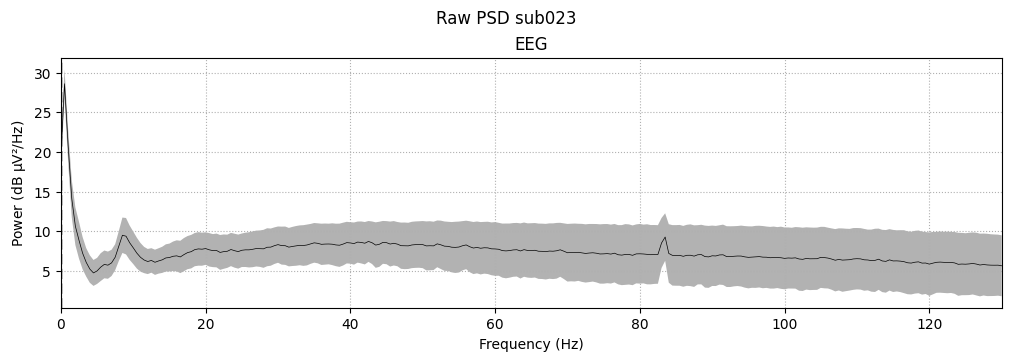

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [5]:
%matplotlib inline

### Plot PSD of signal (averaging all channels)
psd_raw_avg = data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=130, n_fft=round(sf)*2, n_overlap=int(round(sf)), window="hamming")
psd_raw_avg.plot(dB=True, average=True).suptitle(f"Raw PSD {sub}")
plt.show()

### Plot PSD of signal (not averaging)
psd_raw = data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=130, n_fft=round(sf)*2, n_overlap=int(round(sf)), window="hamming")
psd_raw.plot(dB=True, average=False).suptitle(f"Raw PSD {sub}")
sub_save_path = join(saving_path, "sub_data", f"{sub}", "figures", "PSDs")
os.makedirs(sub_save_path, exist_ok=True)  # Create the directory if it doesn't exist
plt.savefig(join(sub_save_path, f"{sub}_raw_PSD_avg.png"), dpi=300)
plt.show()

Using matplotlib as 2D backend.


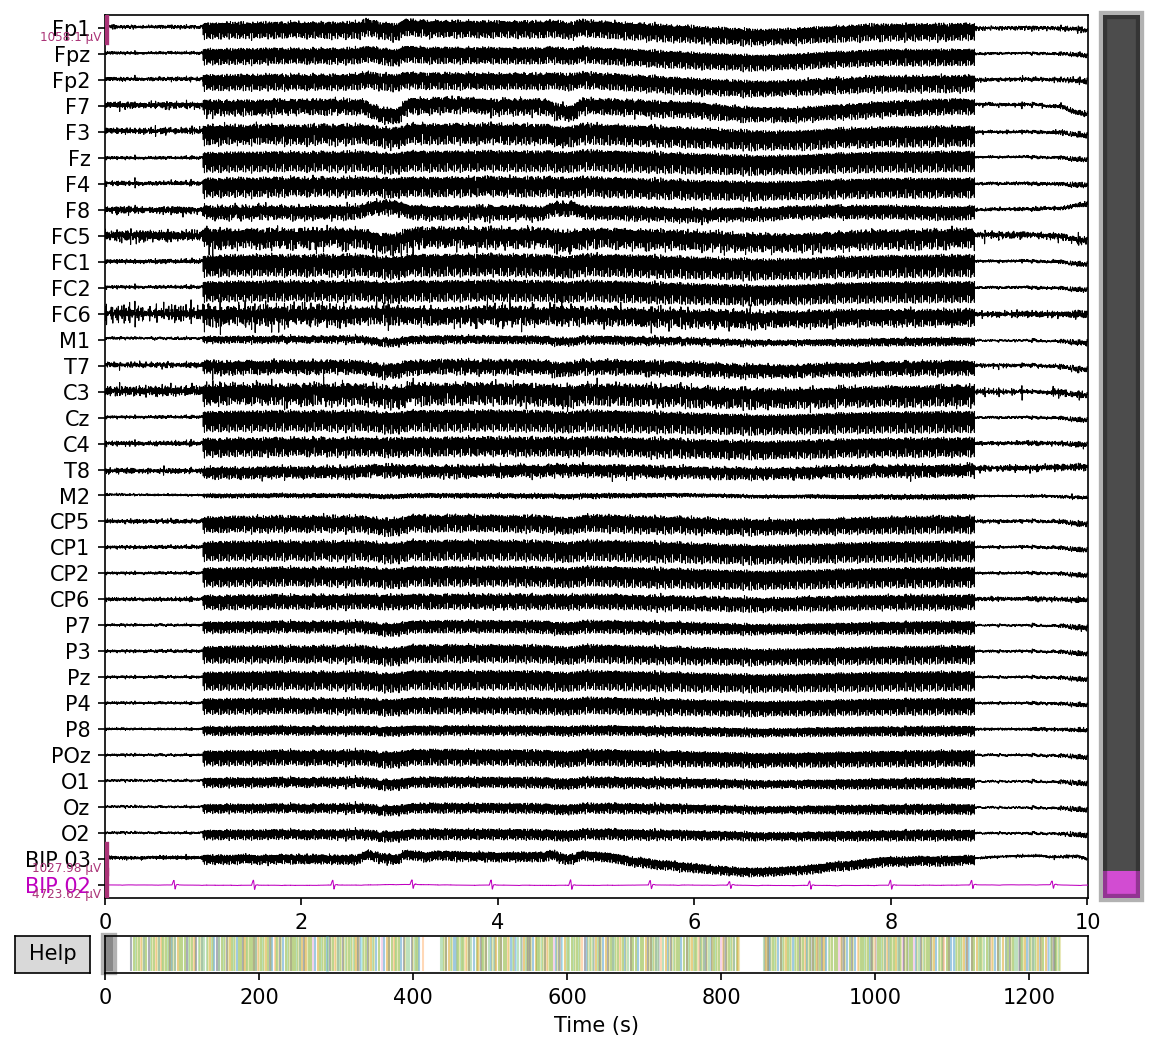

Channels marked as bad:
none


In [6]:
%matplotlib qt
ch_names = data.ch_names
data.plot(n_channels = len(ch_names), scalings="auto", title="Raw data")

### High- and low-pass filtering + notch

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 387 samples (0.189 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.9s finished


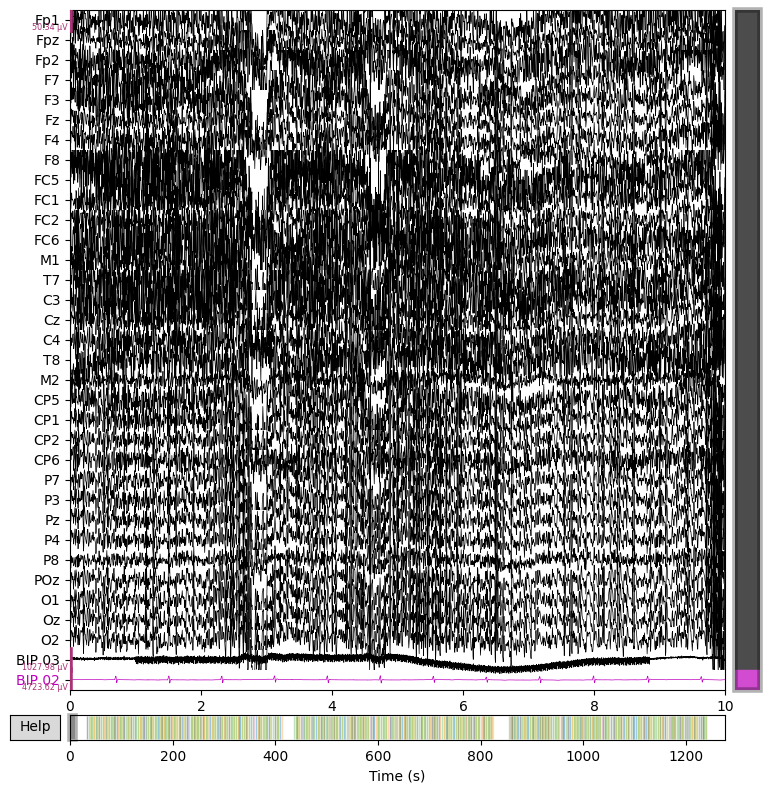

In [ ]:
high_passed_filt_eeg_data = data.copy().filter(1,None) # first apply 1Hz high pass filter
high_low_passed_filt_eeg_data = high_passed_filt_eeg_data.copy().filter(None, 80) # then apply 80Hz low pass filter
# Plot filtered data
high_low_passed_filt_eeg_data.plot(n_channels = len(ch_names), scalings="auto", title="Filtered data")

#### Plot PSD after filtering

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


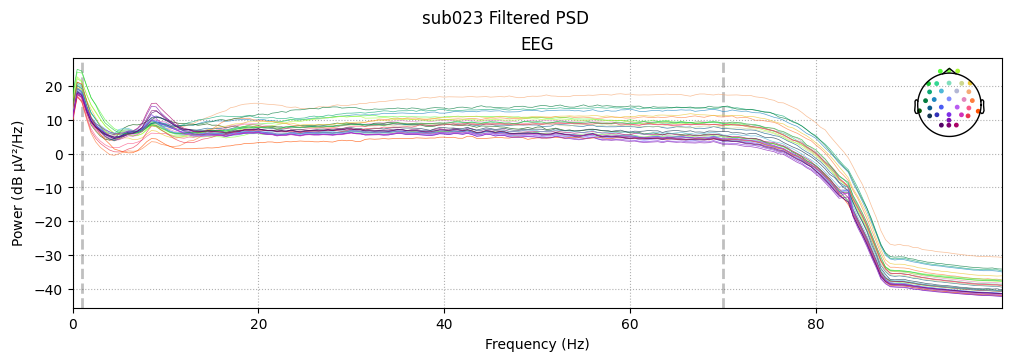

In [10]:
%matplotlib inline

### Plot PSD of signal (averaging all channels)
psd_filt_avg = high_low_passed_filt_eeg_data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=100, n_fft=round(sf)*2, n_overlap=int(round(sf)), window="hamming")
psd_filt_avg.plot(dB=True, average=True).suptitle(f"{sub} Filtered PSD")
plt.show()

### Plot PSD of signal (not averaging)
psd_filt = high_low_passed_filt_eeg_data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=100, n_fft=round(sf)*2, n_overlap=int(round(sf)), window="hamming")
psd_filt.plot(dB=True, average=False).suptitle(f"{sub} Filtered PSD")
plt.show()

In [11]:
notch_filt_eeg_data = high_low_passed_filt_eeg_data.copy().notch_filter(50) # if needed, add notch filter at 50Hz
# Actually, even if 50Hz activity is not present here, it is sometimes present after re-referencing, so it is safer to apply it?

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.2s finished


In [12]:
# Here choose which data to continue with (with or without notch)
filt_eeg_data = notch_filt_eeg_data.copy()  # Use this if you want to keep the notch filter
#filt_eeg_data = high_low_passed_filt_eeg_data.copy() # Use this if you want to skip the notch filter

#### Annotating breaks
Breaks are recognised by time without event markers.
- Min_break_duration: How long time must be between event markers for this to be considered a break.
- t_start_after_previous & t_start_before_next: How many seconds should be after the last event marker before the break starts, and how many seconds before the first event marker should the break stop. 

In [13]:
break_annot = mne.preprocessing.annotate_break(filt_eeg_data, min_break_duration=10, t_start_after_previous=4, t_stop_before_next=4)


Ignoring annotations with descriptions starting with: bad, edge

Detected 4 break periods of >= 10 s duration:
    0.0 – 29.6 s [29.6 s]
    416.4 – 432.4 s [16.0 s]
    827.2 – 851.3 s [24.1 s]
    1243.7 – 1276.0 s [32.3 s]
In total, 8.0% of the data (102.1 s) have been marked as a break.



In [ ]:
### Add the breaks to the annotations of the data
break_data = filt_eeg_data.set_annotations(raw.annotations + break_annot)

##### Visual check to see break is added at the correct places

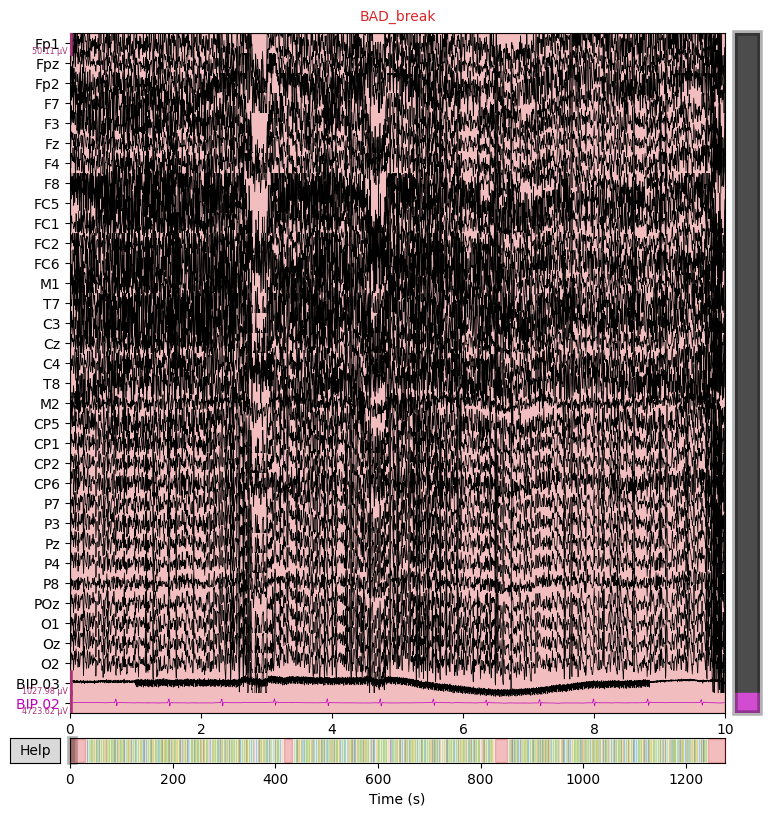

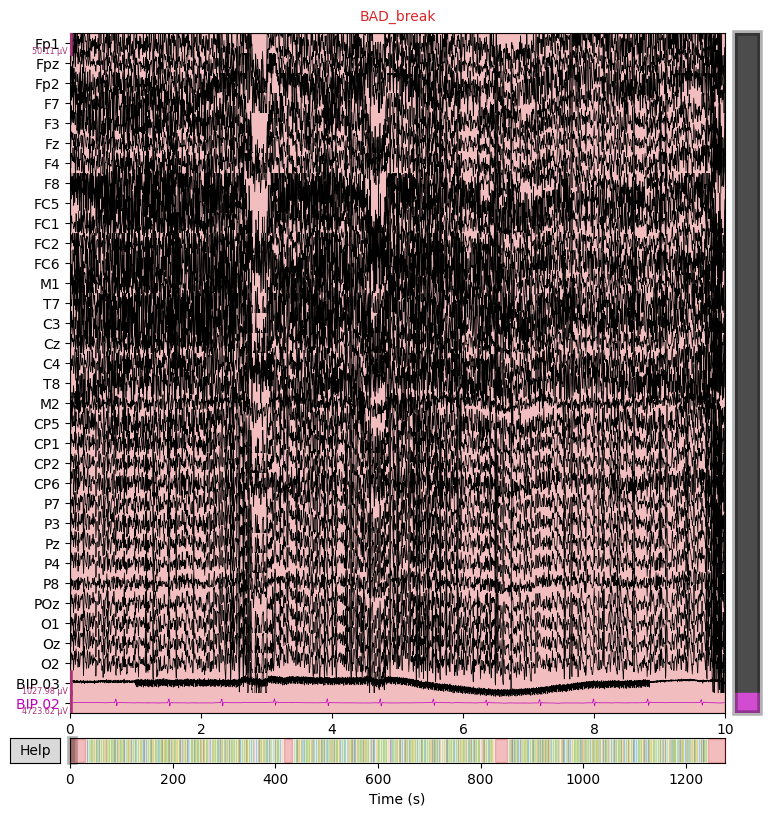

In [ ]:
%matplotlib inline
# Plot signal (can check timeline on x-axis. The red blocks (break) should be where there are no event marker lines)
filt_eeg_data.plot(n_channels = len(ch_names), scalings="auto", title="Breaks added")

#### Plot PSD again - now breaks are not included in the PSD
Depending on how much data has been excluded (i.e. how long the breaks were), and how much artefacts due to movement etc. were in the breaks, the PSD will look more or less like the PSD from before annotating breaks. 

However, it is good to remove breaks from the data when we re-reference to average - we don't want the break activity to influence the average signal.

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


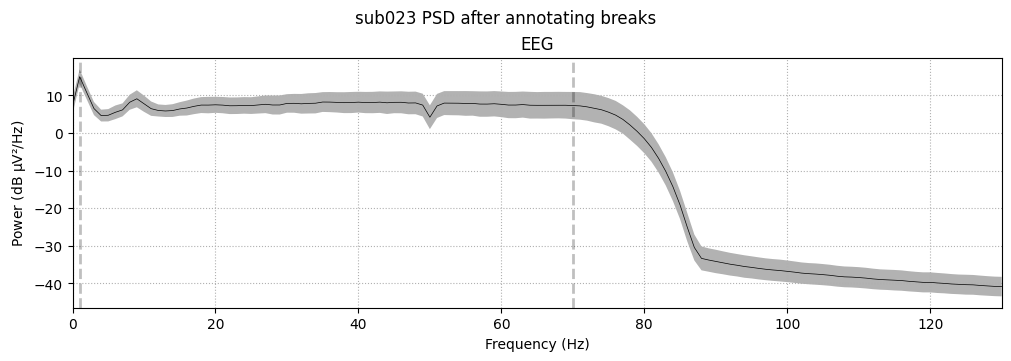

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


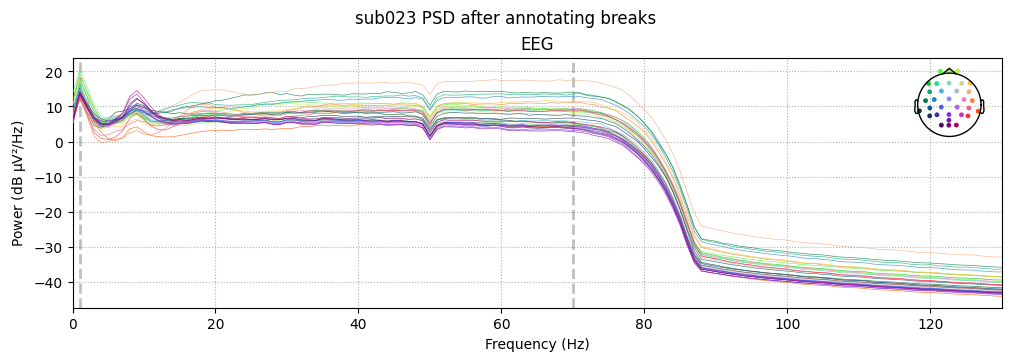

In [16]:
%matplotlib inline

#%matplotlib qt

### Plot PSD of signal (averaging all channels)
psd_noBreak_avg = filt_eeg_data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=130, window="hamming")
psd_noBreak_avg.plot(dB=True, average=True).suptitle(f"{sub} PSD after annotating breaks")
plt.show()

### Plot PSD of signal (not averaging)
psd_noBreakfilt = filt_eeg_data.compute_psd(method="welch", picks="eeg", fmin=0, fmax=130, window="hamming")
psd_noBreakfilt.plot(dB=True, average=False).suptitle(f"{sub} PSD after annotating breaks")
sub_save_path = join(saving_path, "sub_data", f"{sub}", "figures", "PSDs")
plt.savefig(join(sub_save_path, f"{sub}_filtered_noBreak_PSD.png"), dpi=300)
plt.show()

#### Plot data and identify (select by clicking on them) bad channels
Noisy channel identification can also be guided by the PSD above (plotting it interactively you can hover over the channels and get their names). Remove the ones which are clearly way below or above the main groupings of channels (but not frontal ones, they are likely eyeblinks in the lower frequencies). Don't be too strict in removing channels I think - the removing is still something I'm not sure how to best approach. We don't want to remove too much, because then ICA will be bad because we have removed all "noise", but we also want to remove channels that are clearly flat, or only noise. 

After artefact removal, the file is saved.

JV: DO NOT ANNOTATE BAD SEGMENTS! Otherwise, there will be an error later on when trying to match epochs with behavioral data!!

In [17]:
%matplotlib qt

# Plot raw signal
filt_eeg_data.plot(n_channels = len(ch_names), duration = 20, scalings="auto", block=True) # Cell block waits for plot to be closed before continuing (i.e., saving)

save_path = os.path.join(saving_path, "sub_data", f"{sub}", "data")
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

file_p = join(save_path, f"{sub.replace(' ', '_')}_artefacts_removed_EEGdata_eeg.fif")
filt_eeg_data.save(file_p, overwrite=True)

Channels marked as bad:
['FC6', 'T8', 'T7', 'Fp1', 'FC5']
Writing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub023 DBS OFF mSST\sub_data\sub023\data\sub023_artefacts_removed_EEGdata_eeg.fif
Closing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub023 DBS OFF mSST\sub_data\sub023\data\sub023_artefacts_removed_EEGdata_eeg.fif
[done]


##### If already removed artefacts, load file from previous session so we don't need to repeat these steps

In [ ]:
# temp_sub = sub.replace(' ', '_')
# filename = join(saving_path, "sub_data", sub, "data", f"{temp_sub}_artefacts_removed_EEGdata_eeg.fif")

# filt_eeg_break_data = mne.io.read_raw(filename, preload=True)

### Recognising bad channels by Z-scoring and looking at SD and variance in freq. and time domain

**PSD_Z:**
- Computes each channel’s average power (1–90 Hz) in dB, then z-scores across channels—so it flags electrodes whose overall spectral “bulk” is unusually high or low (e.g., a consistently noisy or dead contact) (A single value per channel, tells us whether the channel is generally noisier or quieter than the others) (looks at Frequency domain).

**P2P_Z:**
- Measures the maximum 250 ms peak-to-peak excursion per channel and z-scores those values—so it catches electrodes with extreme transients (cable pops, big spikes) or abnormally flat signals (looks at Time domain)
(Takes the highest voltage the channel reaches minus the lowest voltage it reaches—that difference is its peak-to-peak value.)

**Corr_Z:**
- Computes each channel’s mean Pearson correlation to all other channels, then z-scores—so it flags sensors that aren’t co-varying with the head (e.g., drifty or disconnected channels, channels that don't correlate with their neighbours).

**Var_Z:**
- Takes each channel’s overall variance and z-scores—so it highlights electrodes that are unusually “spiky” or “quiet” over the whole recording (looks at Time domain).

**Max_Freq_Z:**
- Looks for the largest per-frequency deviation (in z-units) from the grand mean spectrum—so it catches narrowband bursts (line-noise leakage, muscle peaks) that might be lost in the broad PSD average (=For each frequency bin look at how many SD above/below the across-channel mean power that channel’s power is at that exact frequency (i.e. a z-score at 10 Hz, at 20 Hz, etc.), and take whichever of those frequency-specific z-scores is largest in absolute value. That way, even if a channel’s overall PSD looks okay, a single narrowband spike (say a 50 Hz line-noise leak or a muscle peak at 80 Hz) will make its “max_freq_z” jump out.) (looks at Frequency domain).

#### Rule of thumb:
- If it fails two or more of the checks, probably bad - but do a visual check of PSD and raw trace
- Failing one check: Look at PSD and raw trace - if looking good, keep it in

**NOTE** Frontal channels can often be flagged, but that is likely because of eyeblinks, so don't necessarily remove them if the raw trace itself looks ok besides the eyeblink!

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 0.078 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
>> PSD outliers (|z|>2.5): ['C3']
>> Peak-to-peak outliers (|z|>2.5): ['M1']
>> Low-correlation outliers (corr_z < -2.5): ['F8', 'M2']
>> Variance outliers (|z|>2.5): ['C3']
>> Spectral‐spike outliers (max_freq_z>2.5): ['C3', 'M2']
>> Final flagged channels: ['F8', 'M1', 'C3', 'M2']
   Channel  PSD_Z  P2P_Z  Corr_Z  Var_Z  Max_Freq_Z  Flagged
0      Fpz  -0.71   0.17    0.21  -0.11        1.21    False
1      Fp2   1.16   0.17   -0.83   1.51        1.75    False
2       F7   0.96   0.46   -1.05   2.05        1.18    False
3       F3   0.90   1.10   -0.06   0.70        1.01    False
4       Fz  -0.85   0.11    0.77  -0.65        0.84    False
5       F4   0.57  -0.10    0.07   0.13        0.63    False
6       F8   1.79  -0.16   -2.85   1.67     

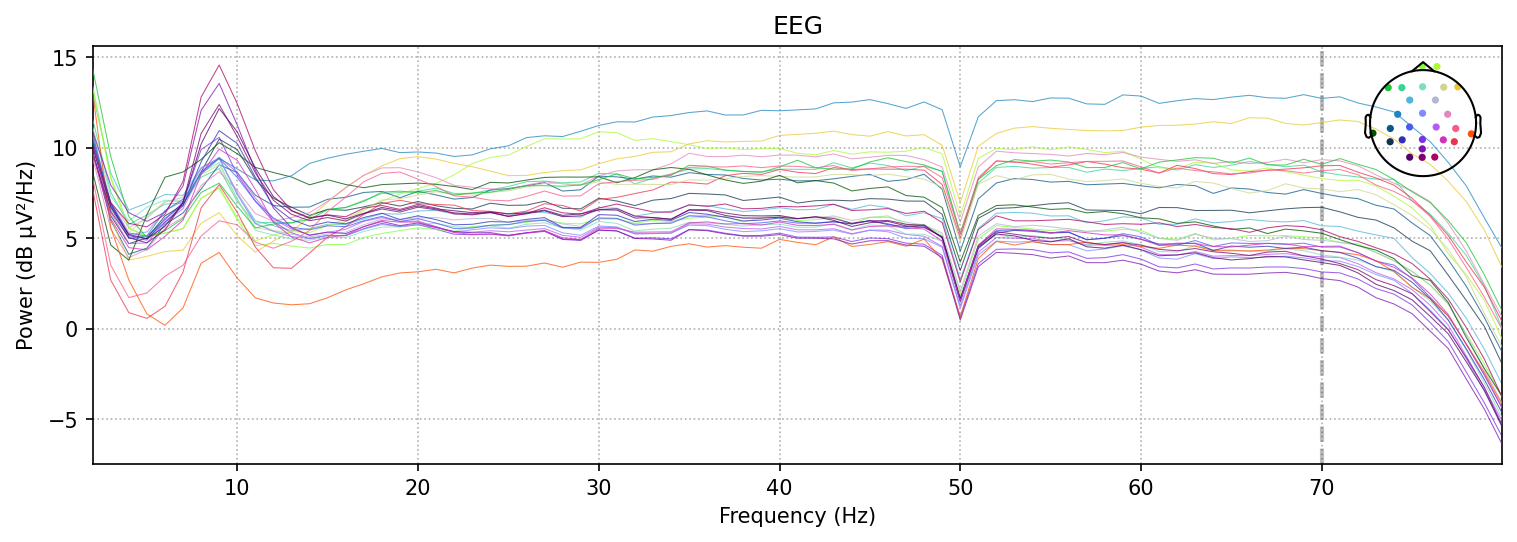

In [18]:
%matplotlib qt

# rename for readability
bad_chan_identifier = filt_eeg_data

# pick only the EEG channels that aren’t already in raw.info['bads']
picks = mne.pick_types(bad_chan_identifier.info, meg=False, eeg=True, exclude='bads')

sfreq = bad_chan_identifier.info['sfreq']

# Frequency-domain PSD checks
psd_container = bad_chan_identifier.compute_psd(
    method="welch",
    picks=picks,
    fmin=1.0,
    fmax=80.0,
    n_fft=160,
    window="hamming"
)

# Convert to dB and compute mean PSD per channel
psds     = psd_container.get_data()     # (n_picks, n_freqs)
psd_db   = 10 * np.log10(psds)
mean_psd = psd_db.mean(axis=1)
psd_z    = (mean_psd - mean_psd.mean()) / mean_psd.std()

# Peak-to-peak amplitude in 250 ms windows
data = bad_chan_identifier.get_data(picks=picks)     # (n_picks, n_times)
win_samp = int(0.25 * sfreq)
n_win    = data.shape[1] // win_samp
p2p_mat  = np.zeros((len(picks), n_win))
for w in range(n_win):
    seg = data[:, w*win_samp:(w+1)*win_samp]
    p2p_mat[:, w] = seg.max(axis=1) - seg.min(axis=1)
max_p2p = p2p_mat.max(axis=1)
p2p_z   = (max_p2p - max_p2p.mean()) / max_p2p.std()

# Channel–channel correlation 
corr      = np.corrcoef(data)
mean_corr = corr.mean(axis=0)
corr_z    = (mean_corr - mean_corr.mean()) / mean_corr.std()

# Compute time-domain variance per channel and z-score
# Flags channels with too much or too little amplitude variability over the rec (relative to the other electrodes),
# i.e., it could be flat or very spiky
chan_vars = np.var(data, axis=1)
var_z     = (chan_vars - chan_vars.mean()) / chan_vars.std()

# Compute frequency-wise z-scores and max deviation per channel
# Looks for channels which have high spikes in some frequencies, could indicate e.g., line noise or muscle artefact
mean_freq   = psd_db.mean(axis=0)
std_freq    = psd_db.std(axis=0)
freq_z      = (psd_db - mean_freq) / std_freq
max_freq_z  = np.max(np.abs(freq_z), axis=1)

# Threshold all metrics at ±2.5 Z
thresh = 2.5
mask_psd   = np.abs(psd_z)    > thresh
mask_p2p   = np.abs(p2p_z)    > thresh
mask_corr  = corr_z           < -thresh    # flag very low corr (z < -2.5)
mask_var   = np.abs(var_z)    > thresh
mask_freq  = max_freq_z       > thresh

# combine
mask_all = mask_psd | mask_p2p | mask_corr | mask_var | mask_freq
bad_channels = [bad_chan_identifier.ch_names[picks[i]]
                for i, m in enumerate(mask_all) if m]

# Print per-metric flagged channels
print(">> PSD outliers (|z|>2.5):", [bad_chan_identifier.ch_names[picks[i]] for i in np.where(mask_psd)[0]])
print(">> Peak-to-peak outliers (|z|>2.5):", [bad_chan_identifier.ch_names[picks[i]] for i in np.where(mask_p2p)[0]])
print(">> Low-correlation outliers (corr_z < -2.5):", [bad_chan_identifier.ch_names[picks[i]] for i in np.where(mask_corr)[0]])
print(">> Variance outliers (|z|>2.5):", [bad_chan_identifier.ch_names[picks[i]] for i in np.where(mask_var)[0]])
print(">> Spectral‐spike outliers (max_freq_z>2.5):", [bad_chan_identifier.ch_names[picks[i]] for i in np.where(mask_freq)[0]])
print(">> Final flagged channels:", bad_channels)

# Summarize in a DataFrame 
df = pd.DataFrame({
    "Channel":     [bad_chan_identifier.ch_names[p]      for p in picks],
    "PSD_Z":       np.round(psd_z,    2),
    "P2P_Z":       np.round(p2p_z,    2),
    "Corr_Z":      np.round(corr_z,   2),
    "Var_Z":       np.round(var_z,    2),
    "Max_Freq_Z":  np.round(max_freq_z,2),
    "Flagged":     mask_all
})
print(df)

# Visual check: all individual PSDs
bad_chan_identifier.plot_psd(
    fmin=1.0, fmax=80.0,
    picks=picks,
    dB=True,
    average=False,
    show=True
)


#### Plot PSD of individual channels flagged above and decide whether to remove or keep them in
For example, if Fp2 and Fp1 are flagged, this is likely eyeblinks (high power in low frequencies), so do not remove it

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Need more than one channel to make topography for eeg. Disabling interactivity.


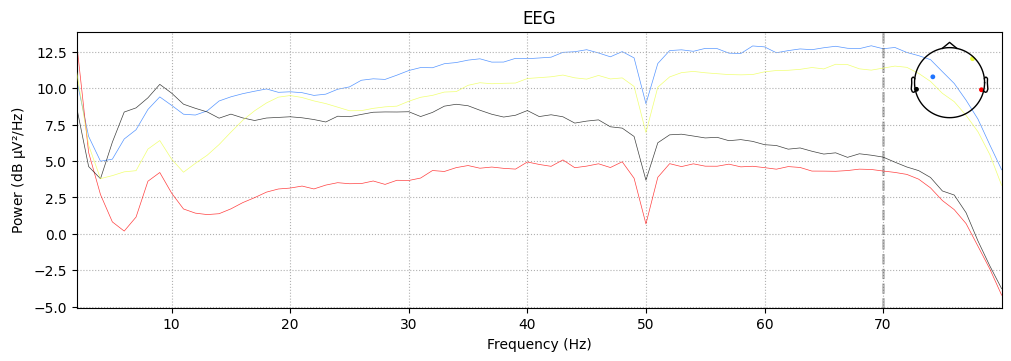

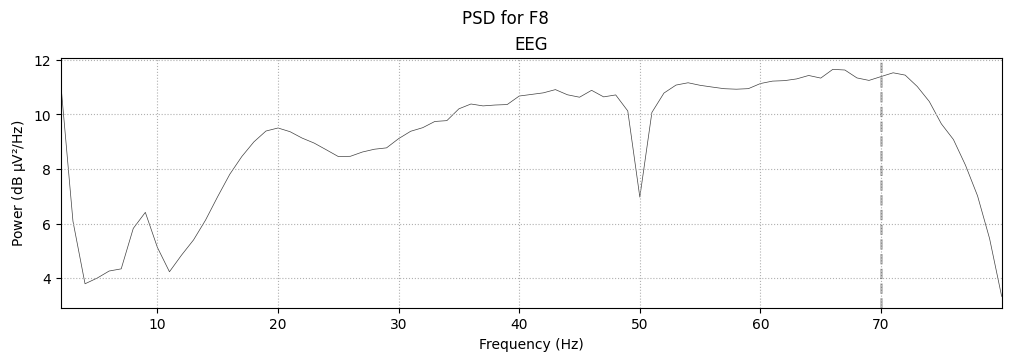

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


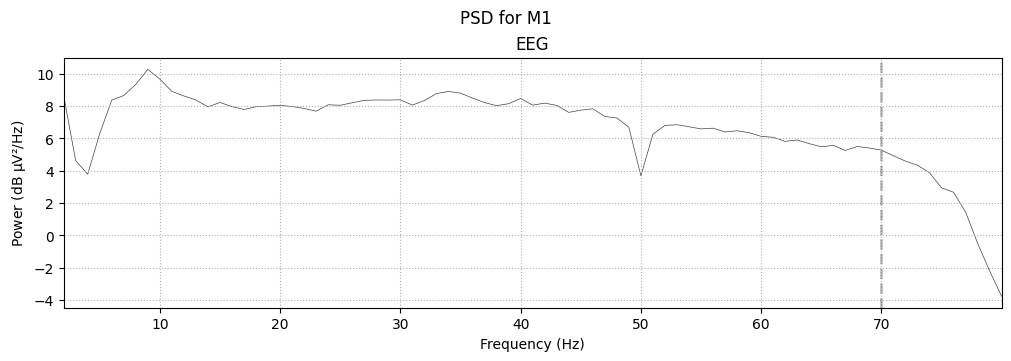

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


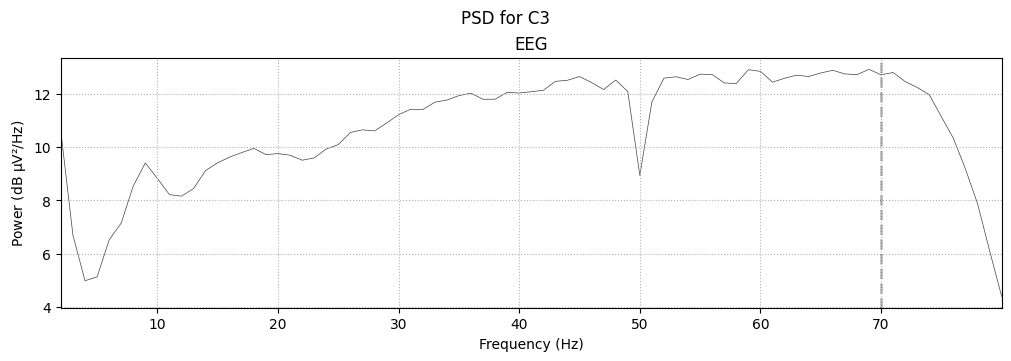

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


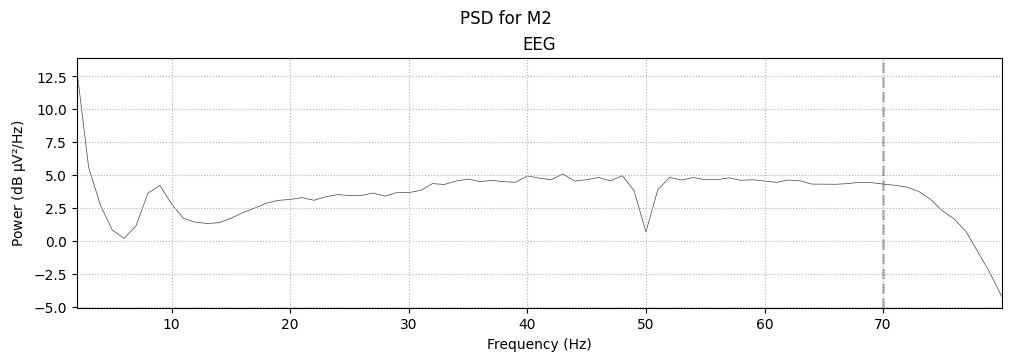

In [19]:
%matplotlib inline 

# picks can be either indices or names
picks = mne.pick_channels(bad_chan_identifier.ch_names, include=bad_channels)

# compute PSD of bad channels
bad_chan_identifier.plot_psd(
    fmin=1.0,
    fmax=80.0,
    picks=picks,
    dB=True,
    average=False,
)

for ch in bad_channels:
    # one figure per channel
    fig = bad_chan_identifier.plot_psd(
        fmin=1.0,
        fmax=80.0,
        picks=[ch],
        dB=True,
        average=False,
        show=False   
    )
    fig.suptitle(f'PSD for {ch}')
    plt.show()


#### Plot channel traces for visual inspection and select bad ones guided by metrics above and visual check here

In [21]:
%matplotlib qt

# Plot raw signal
bad_chan_identifier.plot(n_channels = len(ch_names), scalings="auto", block=True) # Cell block waits for plot to be closed before continuing (i.e., saving)

save_path = os.path.join(saving_path, "sub_data", f"{sub}", "data")
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

file_p = join(save_path, f"{sub.replace(' ', '_')}_art_and_chan_removed_eeg.fif")
bad_chan_identifier.save(file_p, overwrite=True)

Channels marked as bad:
['FC6', 'T8', 'T7', 'Fp1', 'FC5', 'F8', 'M2', 'C3']
Overwriting existing file.
Writing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub023 DBS OFF mSST\sub_data\sub023\data\sub023_art_and_chan_removed_eeg.fif
Closing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub023 DBS OFF mSST\sub_data\sub023\data\sub023_art_and_chan_removed_eeg.fif
[done]


#### After identifying noisy channels and bad segments, re-reference to average
It's important at this step that only channels that are EEG channels, have the EEG label! (see first step of script (after loading data))

In [22]:
 # ensure bad channels are listed here, otherwise they will be included in the average reference
bad_chan_identifier.info['bads']

['FC6', 'T8', 'T7', 'Fp1', 'FC5', 'F8', 'M2', 'C3']

In [23]:
av_ref_data = []
av_ref_data = bad_chan_identifier.copy().set_eeg_reference(ref_channels="average")


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


#### Plot PSD again

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


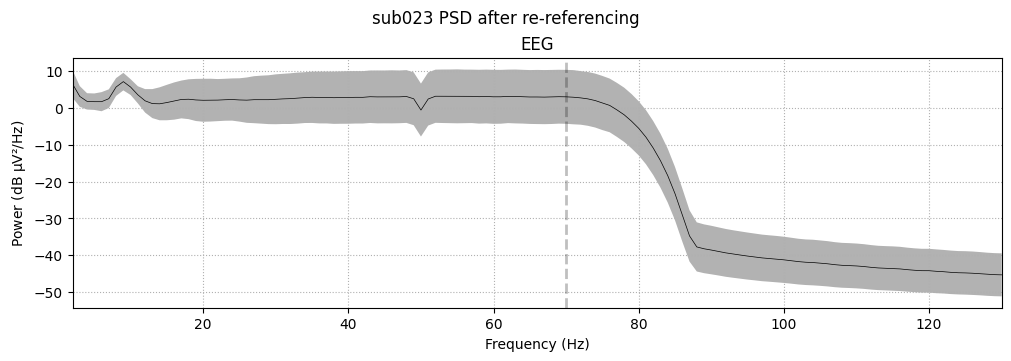

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


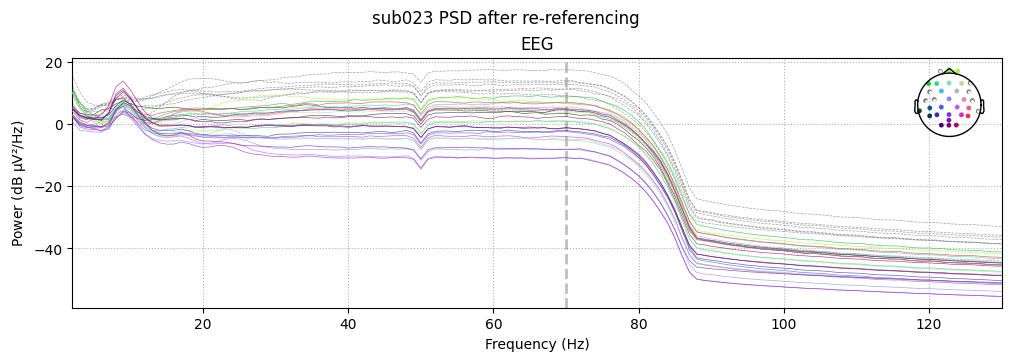

In [24]:
%matplotlib inline

### Plot PSD of signal (averaging all channels)
psd_final_avg = av_ref_data.compute_psd(method="welch", picks="eeg", fmin=1, fmax=130, window="hamming")
psd_final_avg.plot(dB=True, average=True).suptitle(f"{sub} PSD after re-referencing")
plt.show()

### Plot PSD of signal (not averaging)
psd_final = av_ref_data.compute_psd(method="welch", picks="eeg", fmin=1, fmax=130, window="hamming")
psd_final.plot(dB=True, average=False).suptitle(f"{sub} PSD after re-referencing")
sub_save_path = join(saving_path, "sub_data", f"{sub}", "figures", "PSDs")
plt.savefig(join(sub_save_path, f"{sub}_after_reRef.png"), dpi=300)
plt.show()

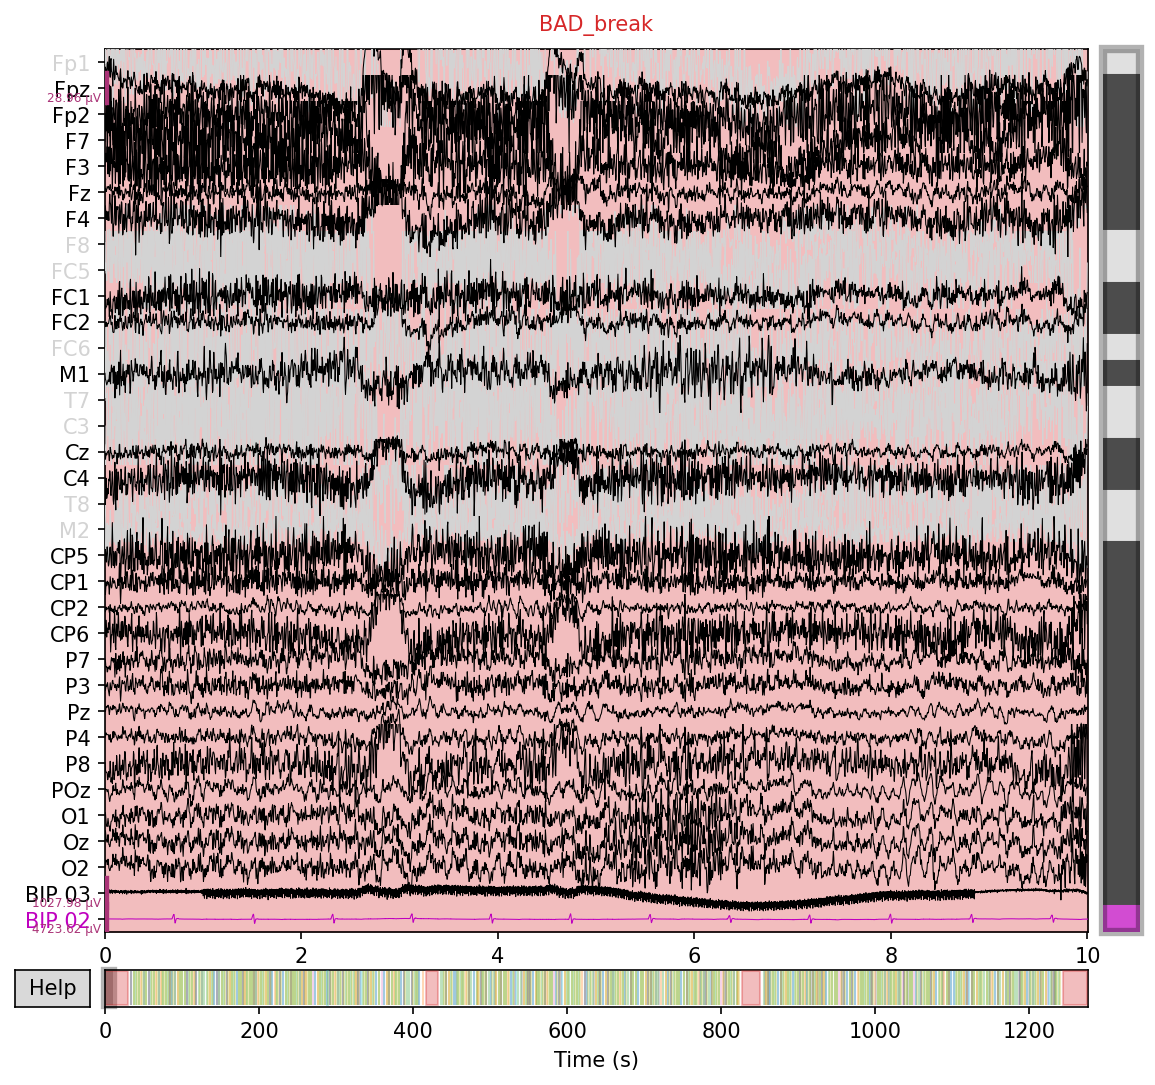

Channels marked as bad:
['FC6', 'T8', 'T7', 'Fp1', 'FC5', 'F8', 'M2', 'C3']


In [25]:
%matplotlib qt
av_ref_data.plot(n_channels = len(ch_names), scalings="auto", title="After re-referencing to average")

### Independent Component Analysis
If ICA has already been fitted for this subject, it will be loaded.
If ICA hasn't been fitted, it will be.

Random note: when cognitive load increases, blinking usually decreases. Because when participants are expecting something important to happen (stimulus appearance), they will unconsciously try not to blink, to pay more attention (source: https://www.youtube.com/watch?v=AXCxrDikpaM)

In [12]:
# Dictionary to store the fitted or loaded ICA objects
ica_fit_dict = {}
 
# Construct the file path for the ICA file
ica_file_path = join(saving_path, 'sub_data', f"{sub}", f"{sub}-ica.fif")
    
# Check if the ICA file exists
if os.path.exists(ica_file_path):
    # If it exists, load the ICA object
    ica = read_ica(ica_file_path)
    print(f"Loaded ICA for {sub} from {ica_file_path}")

else:
    # If it doesn't exist, fit ICA to the data
    ica = ICA(n_components=None, random_state=11, method='infomax') # Number of components is chosen by function to account for 99%
    ica.fit(av_ref_data.copy().pick_types(eeg=True, eog=True, ecg=True))                                  
   
    # Save the ICA object to file (saving the ICA decomposition, not any raw/cleaned data)
    ica.save(ica_file_path)
    print(f"Fitted and saved ICA for {sub} at {ica_file_path}")
    
ica_fit_dict = ica

Reading c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub006 DBS OFF mSST\sub_data\sub006\sub006-ica.fif ...
Now restoring ICA solution ...
Ready.
Loaded ICA for sub006 from c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub006 DBS OFF mSST\sub_data\sub006\sub006-ica.fif


#### Components identified
By clicking on the components you will get more info about them (only in interactive mode (qt))

In [13]:
%matplotlib qt

#%matplotlib inline

fig = ica.plot_components(inst=av_ref_data,  psd_args={'fmin': 0, 'fmax': 80}, ncols=6, nrows=6) #Topographies of each component
plt.savefig(join(sub_save_path, f"{sub}_ica_components.png"), dpi=300)

NameError: name 'av_ref_data' is not defined

In [28]:
for i in range(ica.n_components_):
    fig = ica_fit_dict.plot_properties(picks=[i], inst=av_ref_data, show=False) #Topographies of each component
    plt.savefig(join(sub_save_path, f"{sub}_ica_component_{i}.png"), dpi=300)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items ac

c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\ica.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, facecolor=[0.95] * 3)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
%matplotlib qt
fig_sources = ica.plot_sources(av_ref_data) # Timeseries of each ICA component
plt.savefig(join(sub_save_path, f"{sub}_ica_sources.png"), dpi=300)

Creating RawArray with float64 data, n_channels=25, n_times=2613246
    Range : 0 ... 2613245 =      0.000 ...  1276.008 secs
Ready.


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
584 matching events found
No baseline correction applied
0 projection items ac

#### Which components should be excluded based on their properties and time series (manual exclusion)?


In [30]:
to_exclude = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] # saving this in variable for easier input below

### Exclude components + apply ICA

In [ ]:
ica.exclude = to_exclude # exclude components manually by adding component number here

In [32]:
# Apply ICA to the data
data_after_ica = ica.apply(av_ref_data)

Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 13 ICA components
    Projecting back using 24 PCA components


In [ ]:
ica # here we can check that the correct components have been excluded, gives us ica info

#### Visual inspection after ICA :

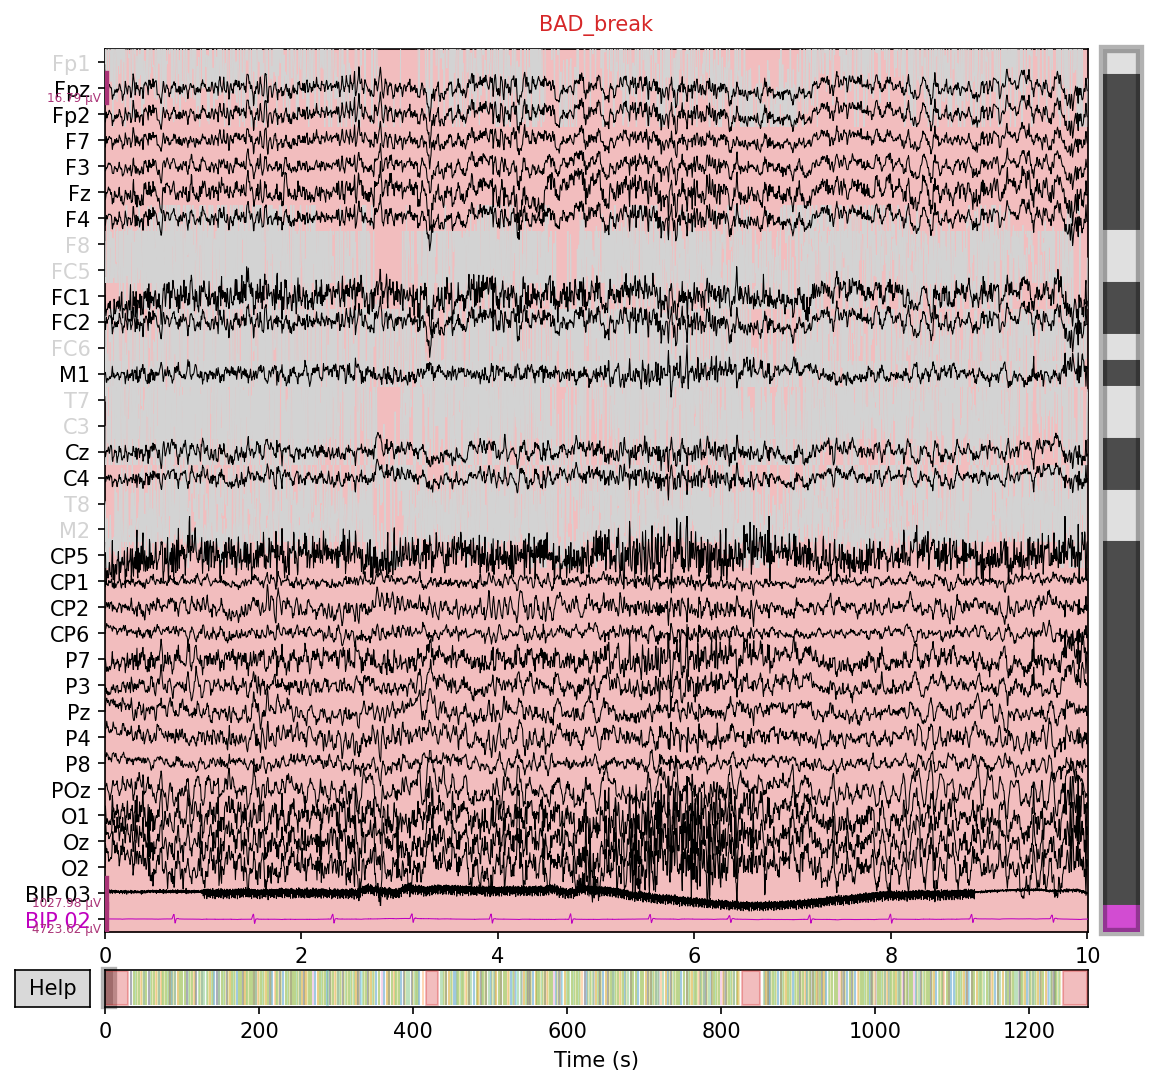

Channels marked as bad:
['FC6', 'T8', 'T7', 'Fp1', 'FC5', 'F8', 'M2', 'C3']


In [33]:
data_after_ica.plot(n_channels=len(ch_names), scalings="auto", title="After ICA")

### If necessary, interpolate bad channels after ICA ###

In [41]:
eeg_data_interp = data_after_ica.copy().interpolate_bads(reset_bads=True)


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.6 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 4 sensors


In [42]:
eeg_data_interp.plot(n_channels=len(ch_names), scalings="auto", title="After ICA and interpolation of bad channels")

NameError: name 'ch_names' is not defined

#### Save file after ICA

In [43]:
save_path = os.path.join(saving_path, "sub_data", f"{sub}", "data")
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

file_p = join(save_path, f"{sub.replace(' ', '_')}_postICA_EEGdata_eeg.fif")
data_after_ica = eeg_data_interp.copy()
data_after_ica.save(file_p, overwrite=True)


Overwriting existing file.
Writing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub019 DBS OFF mSST\sub_data\sub019\data\sub019_postICA_EEGdata_eeg.fif
Closing c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub019 DBS OFF mSST\sub_data\sub019\data\sub019_postICA_EEGdata_eeg.fif
[done]


### Plot PSD after ICA

Setting 209127 of 2613246 (8.00%) samples to NaN, retaining 2404119 (92.00%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


c:\Users\Juliette\anaconda3\envs\ephy\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


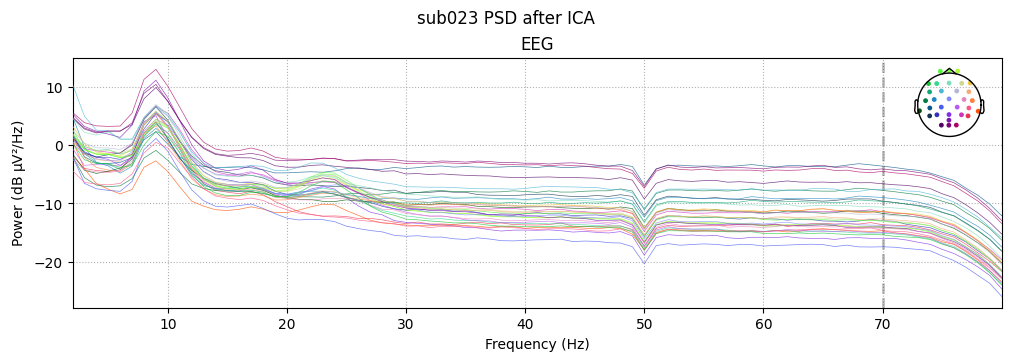

In [55]:
%matplotlib inline

### Plot PSD of signal (not averaging)
psd_after_ica = data_after_ica.compute_psd(method="welch", picks="eeg", fmin=1, fmax=80, window="hamming")
psd_after_ica.plot(dB=True, average=False).suptitle(f"{sub} PSD after ICA")
sub_save_path = join(saving_path, "sub_data", f"{sub}", "figures", "PSDs")
plt.savefig(join(sub_save_path, f"{sub}_after_ICA_PSD.png"), dpi=300)
plt.show()

## Extract epochs to check data quality after ICA and plot specific channels: 
the C3/C4 channels are the ones above the motor cortex, they can be plotted to check that the expected beta desynchronization is visible.

In [56]:
events, event_dict = mne.events_from_annotations(data_after_ica)
# List of keys to keep
keys_to_keep = ['GC', 'GF', 'GO', 'GS', 'continue', 'stop']

# Create the new dictionary by filtering the original one
filtered_event_dict = {key: event_dict[key] for key in keys_to_keep}

print(filtered_event_dict)
# Get the event codes (values) from the filtered dictionary
valid_event_codes = list(filtered_event_dict.values())

# Filter the events array where the event code is in the valid_event_codes list
filtered_events = np.array([event for event in events if event[2] in valid_event_codes])

print(filtered_events)
#picks = [raw.ch_names[0], raw.ch_names[1]]
tmin = -0.5
tmax = 1.5
epochs = mne.Epochs(data_after_ica, filtered_events, event_id=filtered_event_dict, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)
metadata = pd.DataFrame({'subject':[sub] * len(epochs)})
epochs.metadata = metadata

Used Annotations descriptions: ['GC', 'GF', 'GO', 'GS', 'continue', 'early', 'late', 'resp', 'stop']
{'GC': 1, 'GF': 2, 'GO': 3, 'GS': 4, 'continue': 5, 'stop': 9}
[[  68889       0       1]
 [  69160       0       5]
 [  76740       0       3]
 ...
 [2524408       0       5]
 [2530452       0       3]
 [2537691       0       3]]
Not setting metadata
470 matching events found
Setting baseline interval to [-0.5000036073251726, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 470 events and 4097 original time points ...
0 bad epochs dropped
Adding metadata with 1 columns


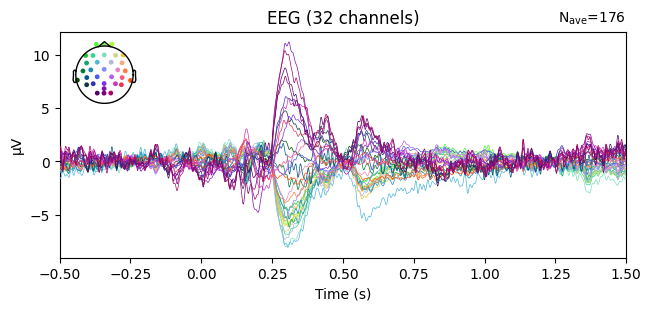

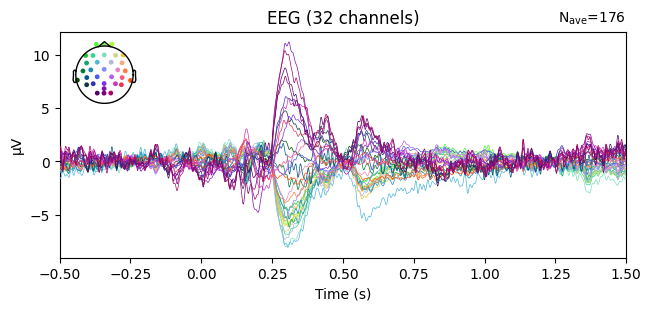

In [57]:
epochs['GO'].average().plot()

In [58]:
# Generate list of evoked objects from conditions names
evokeds = [epochs[name].average() for name in ("GO", "GF","GC", "GS")]

In [59]:
%matplotlib qt
colors = "blue", "red", "green", "black"
title = "Evoked responses"

fig, axes = plt.subplots(1)

mne.viz.plot_evoked_topo(evokeds, title=title, background_color="w", axes=axes)

fig.savefig(join(saving_path, 'evoked_responses.pdf'))

In [60]:
data = io.load_behav_data([session_id], onedrive_path)

stats = {}
stats = utils.extract_stats(data)

sub023 DBS OFF mSST


In [62]:
# Prepare variables and dictionaries for storing results
# Dictionary to store subject epochs in
sub_dict_epochs_subsets = {}  #  Stores the epochs for each condition and for each subject/session
sub_dict_lm_GO = {}  #  Stores the epochs for lm_GO trials for each subject/session
sub_dict_RT = {}  #  Stores the mean reaction time for each trial type
sub_dict_stats = {}  #  Stores behavioral stats for each subject/session

cluster_results_dict = {}
cluster_results_dict = defaultdict(dict)  # Each missing key gets an empty dictionary


In [ ]:
session_dict = {}
sub = session_id[:6]
subject_ID = session_id.split(' ') [0]
condition = session_id.split(' ') [1] + ' ' + session_id.split(' ') [2]
sub_onedrive_path = join(onedrive_path, subject_ID)
sub_onedrive_path_task = join(onedrive_path, subject_ID, 'synced_data', session_id)

saving_path_single = join(results_path, 'single_sub', f'{sub} mSST','eeg') 
os.makedirs(saving_path_single, exist_ok=True)  # Create the directory if it doesn't exist

epochs, filtered_event_dict = preprocessing.create_epochs(data_after_ica, session_id)

mSST_raw_behav_session_data_path = join(
        onedrive_path, subject_ID, "raw_data", 'BEHAVIOR', condition, 'mSST'
        )
for filename in os.listdir(mSST_raw_behav_session_data_path):
        if filename.endswith(".csv"):
            fname = filename
filepath_behav = join(mSST_raw_behav_session_data_path, fname)
df = pd.read_csv(filepath_behav)

# return the index of the first row which is not filled by a Nan value:
start_task_index = df['blocks.thisRepN'].first_valid_index()
# Crop dataframe in 2 parts: before and after the task:
df_maintask = df.iloc[start_task_index:-1]

# remove the trials with early presses, as in these trials the cues were not presented
early_presses = df_maintask[df_maintask['early_press_resp.corr'] == 1]
early_presses_trials = list(early_presses.index)
number_early_presses = len(early_presses_trials)

# remove trials with early presses from the dataframe:
df_maintask_copy = df_maintask.drop(early_presses_trials)

# Filter successful and unsuccessful trials:
(epochs_subsets, epochs_lm, mean_RT_dict) = preprocessing.create_epochs_subsets_from_behav(
        df_maintask_copy, 
        epochs, 
        filtered_event_dict
        )

sub_dict_epochs_subsets[session_id] = epochs_subsets
sub_dict_lm_GO[session_id] = epochs_lm
sub_dict_RT[session_id] = mean_RT_dict
sub_dict_stats[session_id] = stats[session_id]



Used Annotations descriptions: ['GC', 'GF', 'GO', 'GS', 'continue', 'early', 'late', 'resp', 'stop']


Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 470 events and 14337 original time points ...
0 bad epochs dropped
Adding metadata with 1 columns
dict_keys(['GO_successful', 'GO_unsuccessful', 'GS_successful', 'GS_unsuccessful', 'GF_successful', 'GF_unsuccessful', 'GC_successful', 'GC_unsuccessful', 'STOP_successful', 'STOP_unsuccessful', 'CONTINUE_successful', 'CONTINUE_unsuccessful'])


In [64]:
######################
### TFR PARAMETERS ###
######################

decim = 1 
freqs = np.arange(1, 40, 1) 
# For 500ms time resolution at 1 Hz: n_cycles = 1 * 0.5 = 0.5
# For 50ms time resolution at 40 Hz: n_cycles = 40 * 0.05 = 2
# Linear interpolation between these points
#n_cycles = 0.5 + (freqs - 1) * (2 - 0.5) / (40 - 1)
#n_cycles = freqs / 2.0
n_cycles = np.minimum(np.maximum(freqs / 2.0, 2), 10)

tfr_args = dict(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False
)        

tmin_tmax = [-500, 1500]
vmin_vmax = [-70, 70]

In [66]:
single_sub_dict_subsets = {key: value for key, value in sub_dict_epochs_subsets.items() if sub in key}
print(single_sub_dict_subsets.keys())
single_sub_dict_lm_GO = {key: value for key, value in sub_dict_lm_GO.items() if sub in key}
single_sub_RT_dict = {key: value for key, value in sub_dict_RT.items() if sub in key}
single_sub_stats_dict = {key: value for key, value in sub_dict_stats.items() if sub in key}
saving_path_single = join(results_path, 'single_sub', f'{sub} mSST','lfp_perc_sig_change', 'beta_only')
os.makedirs(saving_path_single, exist_ok=True)  # Create the directory if it doesn't exist


dict_keys(['sub023 DBS OFF mSST'])


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


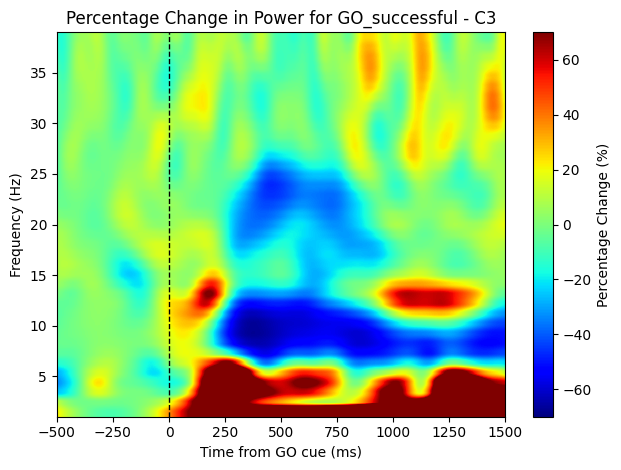

In [67]:
%matplotlib inline
epoch_cond = 'GO_successful'
t_min_max = [-500, 1500]
data = epochs_subsets[epoch_cond]
C4_epochs = data.copy().pick(["C3"])
power_c4 = C4_epochs.compute_tfr(**tfr_args)
mean_power_c4 = np.nanmean(power_c4.data, axis=0).squeeze()

times = power_c4.times * 1000  # Convert to milliseconds
freqs = power_c4.freqs

baseline_indices = (times >= -500) & (times <= -200)
baseline_power_c4 = np.nanmean(mean_power_c4[:, baseline_indices], axis=1, keepdims=True)
percentage_change_c4 = (mean_power_c4 - baseline_power_c4) / baseline_power_c4 * 100

time_indices = np.logical_and(times >= t_min_max[0], times <= t_min_max[1])
sliced_data = percentage_change_c4[:, time_indices].squeeze()    

plt.imshow(sliced_data, aspect='auto', origin='lower', 
        extent=[t_min_max[0], t_min_max[1], 
        tfr_args["freqs"][0], tfr_args["freqs"][-1]], 
        cmap='jet', vmin=vmin_vmax[0], vmax=vmin_vmax[-1]
)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.title(f"Percentage Change in Power for {epoch_cond} - C3")
plt.xlabel("Time from GO cue (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Percentage Change (%)")
plt.tight_layout()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


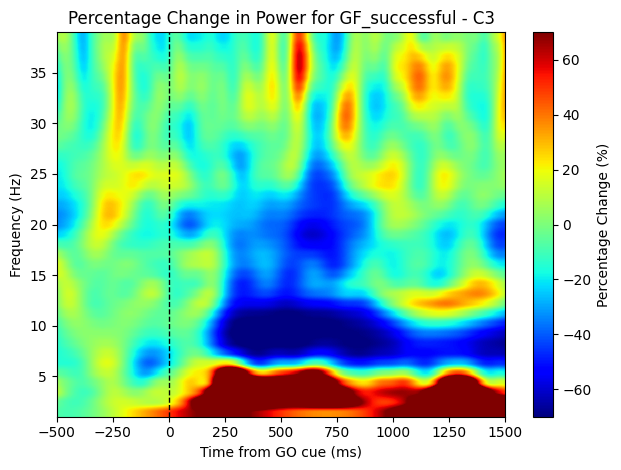

In [68]:
epoch_cond = 'GF_successful'
t_min_max = [-500, 1500]
data = epochs_subsets[epoch_cond]
C4_epochs = data.copy().pick(["C3"])
power_c4 = C4_epochs.compute_tfr(**tfr_args)
mean_power_c4 = np.nanmean(power_c4.data, axis=0).squeeze()

times = power_c4.times * 1000  # Convert to milliseconds
freqs = power_c4.freqs

baseline_indices = (times >= -500) & (times <= -200)
baseline_power_c4 = np.nanmean(mean_power_c4[:, baseline_indices], axis=1, keepdims=True)
percentage_change_c4 = (mean_power_c4 - baseline_power_c4) / baseline_power_c4 * 100

time_indices = np.logical_and(times >= t_min_max[0], times <= t_min_max[1])
sliced_data = percentage_change_c4[:, time_indices].squeeze()    

plt.imshow(sliced_data, aspect='auto', origin='lower', 
        extent=[t_min_max[0], t_min_max[1], 
        tfr_args["freqs"][0], tfr_args["freqs"][-1]], 
        cmap='jet', vmin=vmin_vmax[0], vmax=vmin_vmax[-1]
)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.title(f"Percentage Change in Power for {epoch_cond} - C3")
plt.xlabel("Time from GO cue (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Percentage Change (%)")
plt.tight_layout()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


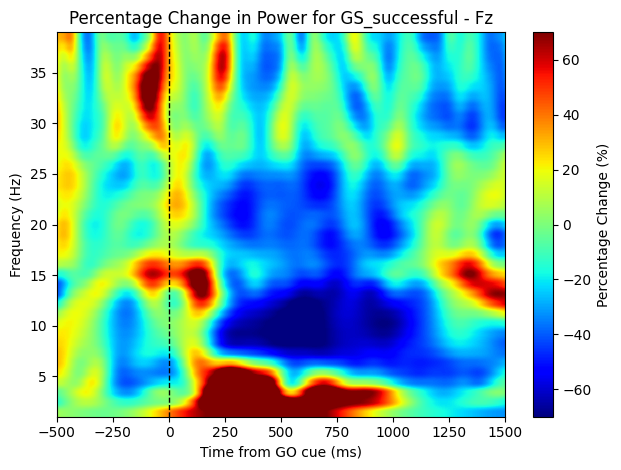

In [48]:
epoch_cond = 'GS_successful'
t_min_max = [-500, 1500]
data = epochs_subsets[epoch_cond]
fz_epochs = data.copy().pick(["Fz"])
power_fz = fz_epochs.compute_tfr(**tfr_args)
mean_power_fz = np.nanmean(power_fz.data, axis=0).squeeze()

times = power_fz.times * 1000  # Convert to milliseconds
freqs = power_fz.freqs

baseline_indices = (times >= -500) & (times <= -200)
baseline_power_fz = np.nanmean(mean_power_fz[:, baseline_indices], axis=1, keepdims=True)
percentage_change_fz = (mean_power_fz - baseline_power_fz) / baseline_power_fz * 100

time_indices = np.logical_and(times >= t_min_max[0], times <= t_min_max[1])
sliced_data_fz = percentage_change_fz[:, time_indices].squeeze()    

plt.imshow(sliced_data_fz, aspect='auto', origin='lower', 
        extent=[t_min_max[0], t_min_max[1], 
        tfr_args["freqs"][0], tfr_args["freqs"][-1]], 
        cmap='jet', vmin=vmin_vmax[0], vmax=vmin_vmax[-1]
)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.title(f"Percentage Change in Power for {epoch_cond} - Fz")
plt.xlabel("Time from GO cue (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Percentage Change (%)")
plt.tight_layout()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


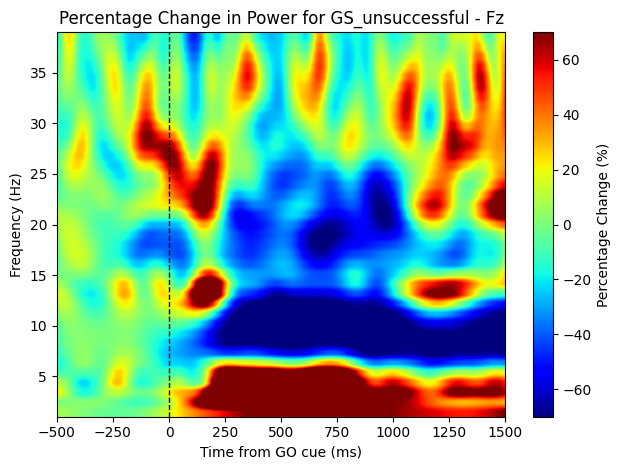

In [49]:
epoch_cond = 'GS_unsuccessful'
t_min_max = [-500, 1500]
data = epochs_subsets[epoch_cond]
fz_epochs = data.copy().pick(["Fz"])
power_fz = fz_epochs.compute_tfr(**tfr_args)
mean_power_fz = np.nanmean(power_fz.data, axis=0).squeeze()

times = power_fz.times * 1000  # Convert to milliseconds
freqs = power_fz.freqs

baseline_indices = (times >= -500) & (times <= -200)
baseline_power_fz = np.nanmean(mean_power_fz[:, baseline_indices], axis=1, keepdims=True)
percentage_change_fz = (mean_power_fz - baseline_power_fz) / baseline_power_fz * 100

time_indices = np.logical_and(times >= t_min_max[0], times <= t_min_max[1])
sliced_data_fz = percentage_change_fz[:, time_indices].squeeze()    

plt.imshow(sliced_data_fz, aspect='auto', origin='lower', 
        extent=[t_min_max[0], t_min_max[1], 
        tfr_args["freqs"][0], tfr_args["freqs"][-1]], 
        cmap='jet', vmin=vmin_vmax[0], vmax=vmin_vmax[-1]
)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.title(f"Percentage Change in Power for {epoch_cond} - Fz")
plt.xlabel("Time from GO cue (ms)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Percentage Change (%)")
plt.tight_layout()

#### NOTE: Here I have kept ALL epochs, even if they have previously been marked as bad (e.g.,movement), and I will have to remove these again now. 

### Note
Once each subject has been preprocessed and epochs cleaned, other scripts will load the cleaned epochs and run the analyses.